# HW 10 CLUSTERING BUSINESS

# cluster time trends in NYC businesses: 
# DATA
# Census Business data:
## download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
## and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



$ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

$ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

$ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


# NYC zip codes shape file is here
## http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

import pandas as pd

import zipfile  #i am not giving it a name cause i intend to use it only once

zf = zipfile.ZipFile('zbp13totals.zip')
df = pd.read_csv(zf.open('zbp1ztotals.zip'.replace('.zip','.txt')))



you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (Ntimestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [638]:
import pylab as pl
import numpy as np
import pandas as pd
import json
import urllib2
import matplotlib.pyplot as plt
%pylab inline
plt.style.use('ggplot')
import sklearn.cluster
from sklearn import mixture
import random 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## 1. Get and Prepare Data

In [639]:
# explore the data
import zipfile  #i am not giving it a name cause i intend to use it only once

zf = zipfile.ZipFile('zbp98totals.zip')
df = pd.read_csv(zf.open('zbp98totals.zip'.replace('.zip','.txt')))

#df

In [640]:
# extract the zipcode in nyc

url = "https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson"
request = urllib2.urlopen(url)
nyc = json.load(request)
# nyc
zipcode = []
for i in nyc['features']:
    zipcode.append(int(i['properties']['postalCode']))
    
# len(zipcode)

In [641]:
# define a function for extracting the data

yearlist = [str(i)[-2:] for i in (range(1994,2014))]

# for 94-97 and 03-13
def extractdata(year):
    zf = zipfile.ZipFile('zbp%stotals.zip'%(year))
    df = pd.read_csv(zf.open(('zbp%stotals.zip'%(year)).replace('.zip','.txt')))
    df = df[df['zip'].isin(zipcode)].loc[:,['zip','est']].set_index('zip')
    df.columns=['%s'%(year)]
    return df

# for 98-02 with uppercase
def Extractdata(year):
    zf = zipfile.ZipFile('zbp%stotals.zip'%(year))
    df = pd.read_csv(zf.open(('zbp%stotals.zip'%(year)).replace('.zip','.txt')))
    df = df[df['ZIP'].isin(zipcode)].loc[:,['ZIP','EST']].set_index('ZIP')
    df.columns=['%s'%(year)]
    return df

In [642]:
# extract and merge the data

dfin = pd.DataFrame(index=zipcode)
for i in yearlist[:4]:
    dfin = pd.merge(dfin, extractdata(i), left_index=True, right_index=True)
for i in yearlist[4:9]:
    dfin = pd.merge(dfin, Extractdata(i), left_index=True, right_index=True)
for i in yearlist[9:]:
    dfin = pd.merge(dfin, extractdata(i), left_index=True, right_index=True)

print dfin.shape

(243, 20)


In [643]:
# drop the Nan and duplicates

finaldata = dfin[dfin > 0]
finaldata = finaldata.dropna(how='any')
finaldata = finaldata.drop_duplicates()
finaldata.columns=(range(1994,2014))
print finaldata.shape
# finaldata

(230, 20)


In [644]:
# "whitening" the data

df = finaldata.copy()
for i in range(len(finaldata)):
    df.iloc[i] = (df.iloc[i]-np.mean(df.iloc[i]))/np.std(df.iloc[i])

df.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
10001,-1.831632,-1.173250,-1.269418,-0.685012,0.054742,-0.100607,0.520787,-0.433496,-0.781180,-1.202840,0.912857,0.483799,1.245746,2.237017,1.667406,0.432016,-0.041426,-0.144992,-0.085811,0.195295
10002,-1.722813,-1.631907,-1.372173,-1.034519,-1.153997,-0.941015,-0.442326,0.248565,-0.463105,-0.117659,0.269344,0.609595,0.619984,0.617387,0.632971,0.851147,1.103089,1.206982,1.316071,1.404380
10003,-1.872528,-1.457250,-1.319968,-0.914985,-0.523731,-0.489411,-0.407041,-0.685038,-0.636989,-0.334968,-0.087861,0.224456,0.368602,0.849090,0.924595,1.020693,1.068741,1.226616,1.415379,1.631598
10004,-1.608897,-1.523770,-1.438643,-1.060302,-1.031926,-0.492790,0.084181,-0.360370,-0.303619,-0.313078,-0.019863,-0.237409,0.244976,0.803030,0.859781,0.888157,1.067869,1.124620,1.484044,1.834010
10005,-2.885957,-2.304004,-0.417066,-0.223082,0.535220,0.041442,0.835014,0.164887,0.076712,-0.699225,-0.240717,-0.452336,0.341236,0.588125,0.905554,0.605760,0.464681,1.081903,0.588125,0.993729


## 2.  K-mean Clustering

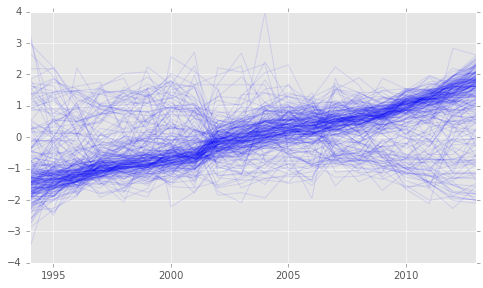

In [645]:
# expolre the data on plot

pl.figure(figsize=(8,4.5))
pl.xlim(1994,2013)
for i in range(len(df)):
    pl.plot(df.iloc[i], c='b', alpha=0.1)

In [646]:
col= [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

In [647]:
# define a founction for cluster and plot

def clusterandplot(num_cluster):
    
    #cluster
    clf=sklearn.cluster.KMeans(n_clusters = num_cluster)
    clf.fit(df.values)
    labels=clf.labels_
    centers = clf.cluster_centers_
    
    
    #plot
    pl.figure(figsize=(8,4.5))
    pl.xlim(1994,2013)
    pl.title('%d clusters'%(num_cluster))
    
    for i in range(len(df)):
        pl.plot(df.iloc[i], c=col[labels[i]], alpha=0.1)
        
    
    mum_intercluster=[]
    for j in range(num_cluster):
        pl.plot(range(1994,2014),centers[j],'-',c=col[j],linewidth=5)
        
        mum_intercluster.append(len([i for i in labels if i == j]))
        
    print "for %d clusters, the number of lines in each clusters is"%(num_cluster), mum_intercluster
    

for 2 clusters, the number of lines in each clusters is [177, 53]
for 3 clusters, the number of lines in each clusters is [173, 34, 23]
for 4 clusters, the number of lines in each clusters is [30, 33, 16, 151]
for 5 clusters, the number of lines in each clusters is [132, 25, 39, 16, 18]
for 6 clusters, the number of lines in each clusters is [140, 14, 14, 13, 31, 18]


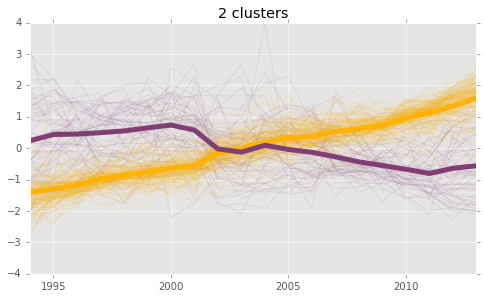

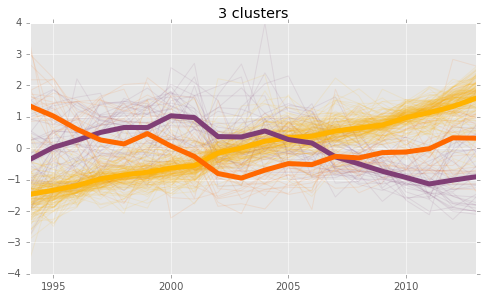

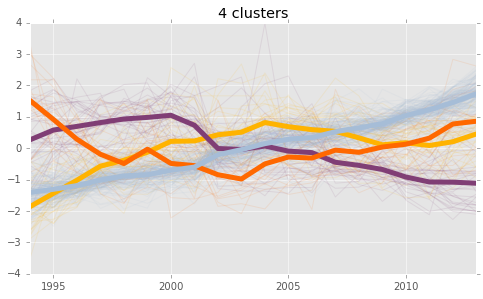

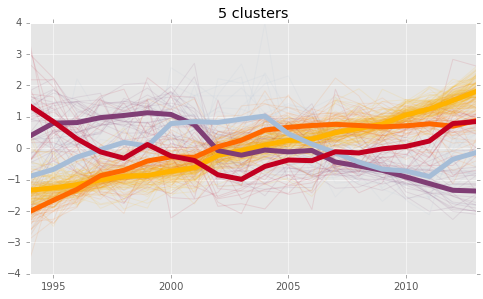

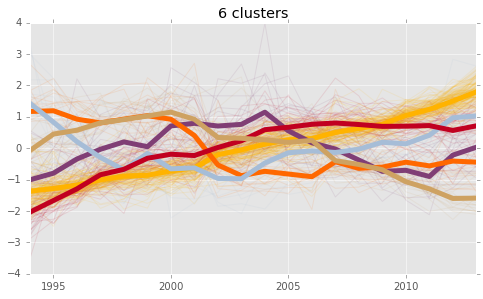

In [648]:
# cluster and plot

for i in range(2,7):
    clusterandplot(i)

## 3. Other Clustering Algorithm

In [754]:
# Agglomerative Clustering

def Aggcluster(num_cluster):
    
    #cluster
    clf=AgglomerativeClustering(n_clusters = num_cluster)
    clf.fit(df.values)
    labels=clf.labels_
    
    
    #plot
    pl.figure(figsize=(8,4.5))
    pl.xlim(1994,2013)
    pl.title('%d Clusters for Agglomerative Clustering'%(num_cluster))
    
    for i in range(len(df)):
        pl.plot(df.iloc[i], c=col[labels[i]], alpha=0.5)
        
    
    mum_intercluster=[]
    for j in range(num_cluster):
        mum_intercluster.append(len([i for i in labels if i == j]))
        
    print "for %d clusters, the number of lines in each clusters is"%(num_cluster), mum_intercluster


for 2 clusters, the number of lines in each clusters is [61, 169]
for 3 clusters, the number of lines in each clusters is [27, 169, 34]
for 4 clusters, the number of lines in each clusters is [169, 18, 34, 9]
for 5 clusters, the number of lines in each clusters is [34, 18, 151, 9, 18]
for 6 clusters, the number of lines in each clusters is [18, 15, 151, 9, 18, 19]


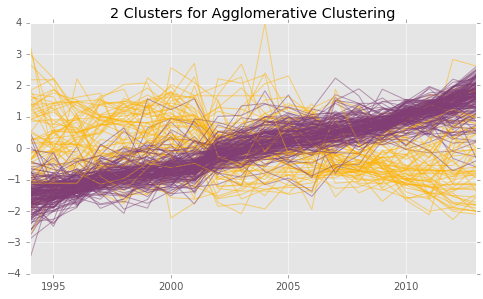

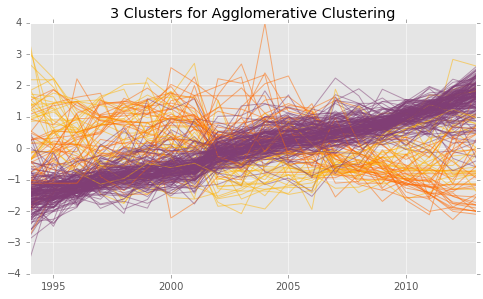

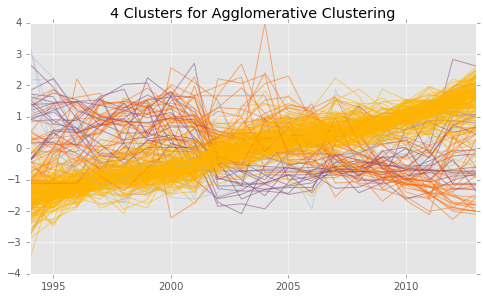

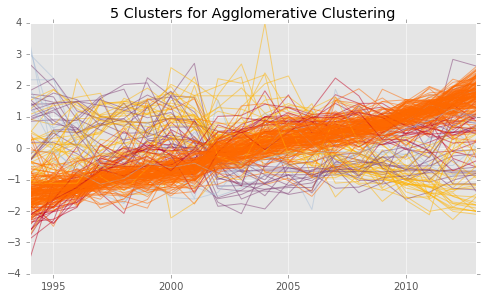

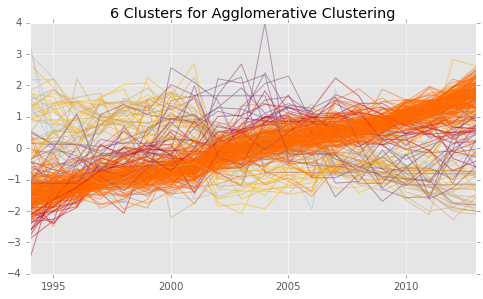

In [755]:
for i in range(2,7):
    Aggcluster(i)

## 4. Overlay the data on NYC map

for 3 clusters, the number of lines in each clusters is [34, 174, 22]


/Users/Tianqi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


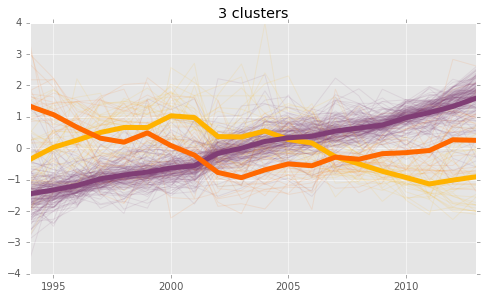

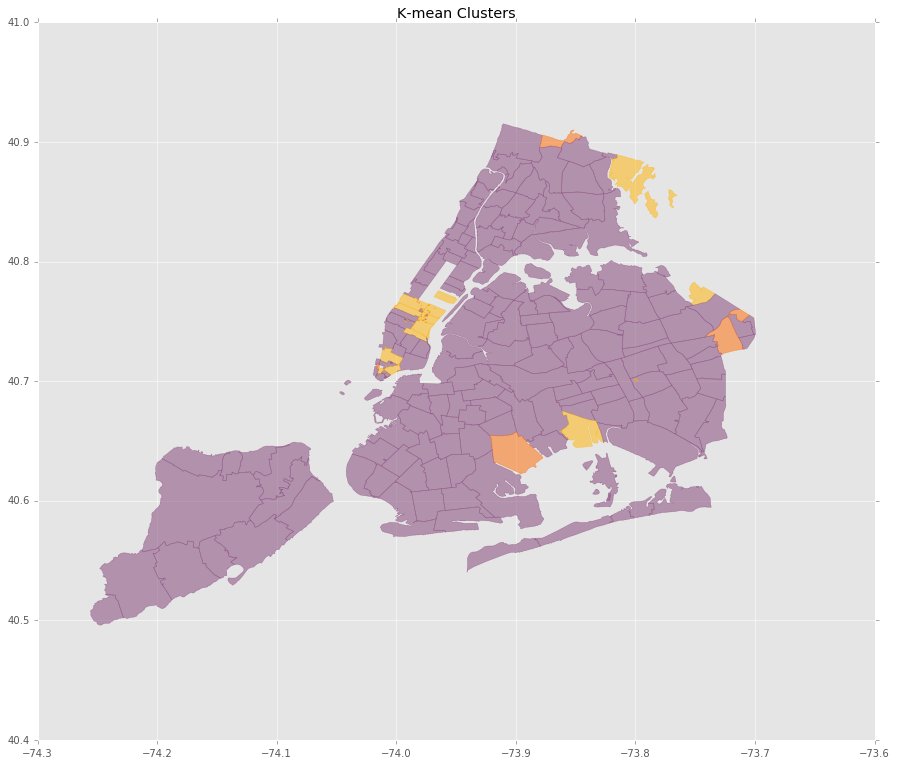

In [748]:
# Overlay k-mean clustering on map

# cluster
clf=sklearn.cluster.KMeans(n_clusters = 3)
clf.fit(df.values)
labels=clf.labels_
centers = clf.cluster_centers_
 
# plot
pl.figure(figsize=(8,4.5))
pl.xlim(1994,2013)
pl.title('%d clusters'%(3))

for i in range(len(df)):
    pl.plot(df.iloc[i], c=col[labels[i]], alpha=0.1)

mum_intercluster=[]
for j in range(3):
    pl.plot(range(1994,2014),centers[j],'-',c=col[j],linewidth=5)

    mum_intercluster.append(len([i for i in labels if i == j]))

print "for %d clusters, the number of lines in each clusters is"%(3), mum_intercluster
    
# plot on map

zip = pd.DataFrame(df.index)
zip.columns=['zipcode']

from descartes import PolygonPatch

fig = plt.figure(figsize=(15,15)) 
for i in nyc['features']:
    poly = i['geometry']
    postcode = int(i['properties']['postalCode'])
    ax = fig.gca()
    if postcode in list(df.index):
        color = col[labels[zip[zip['zipcode']==postcode].index]]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5))
ax.axis('scaled')

plt.title('K-mean Clusters')

for 3 clusters, the number of lines in each clusters is [27, 169, 34]


/Users/Tianqi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


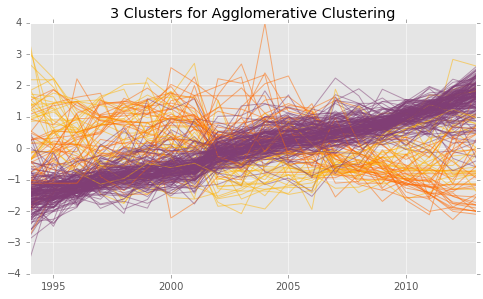

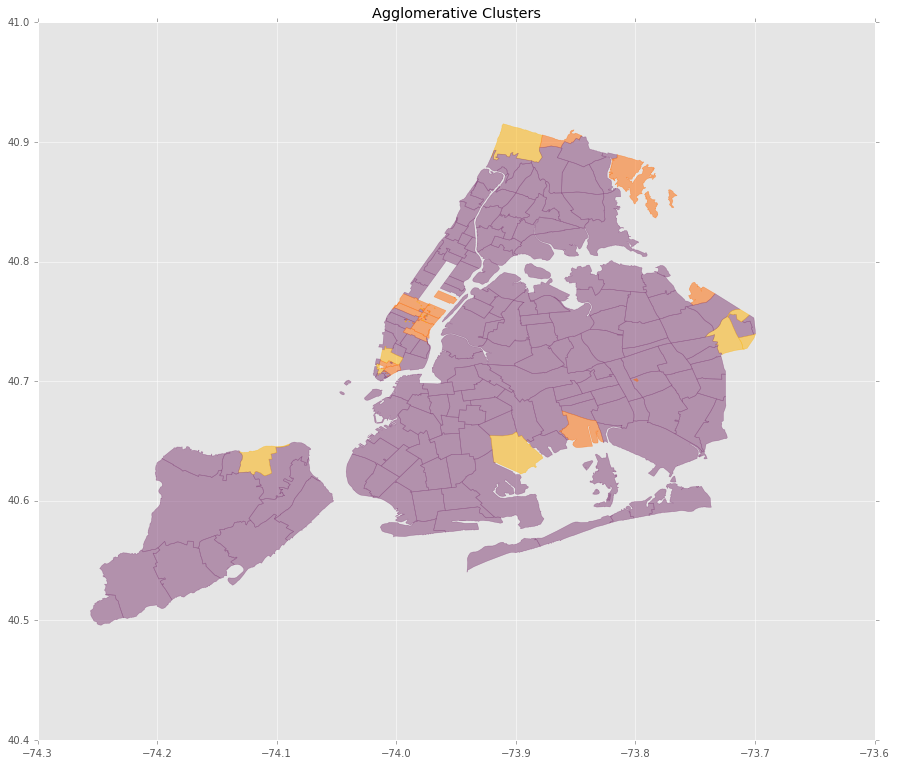

In [752]:
# Overlay agglomerative clustering on map

# cluster
clf=AgglomerativeClustering(n_clusters = 3)
clf.fit(df.values)
labels=clf.labels_

# plot
pl.figure(figsize=(8,4.5))
pl.xlim(1994,2013)
pl.title('%d Clusters for Agglomerative Clustering'%(3))

for i in range(len(df)):
    pl.plot(df.iloc[i], c=col[labels[i]], alpha=0.5)


mum_intercluster=[]
for j in range(3):
    mum_intercluster.append(len([i for i in labels if i == j]))

print "for 3 clusters, the number of lines in each clusters is", mum_intercluster

# plot on map

fig = plt.figure(figsize=(15,15)) 
for i in nyc['features']:
    poly = i['geometry']
    postcode = int(i['properties']['postalCode'])
    ax = fig.gca()
    if postcode in list(df.index):
        color = col[labels[zip[zip['zipcode']==postcode].index]]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5))
ax.axis('scaled')

plt.title('Agglomerative Clusters')

## 5. Compare and Interpretation

a) According to the clustering results and the number of elements in each cluster, I found setting 2 clusters or 3 clusters are better than the others. When setting 2 clusters or 3 clusters, the difference betweent lines trends is more clear, and when the clusters number increase, the number of elements in the main cluster doesn't change much.

b) Comparing the two clustering algorithm, the results are similar. That means the clustering could make sence.

c) Accorinding to the result and the map, I can tell that in the past 20 years and in most of areas in NYC, the number of establishments was keeping increasing. Just in a few areas, such as the midtown, the number of establishments didn't change much or decreased. 